In [329]:
from pathlib import Path
from IPython.display import display

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import spotipy
import lib_spotify_app.api_adapter as api_adapter

pd.set_option('max_columns', None)

In [330]:
df = pd.read_csv(Path(r'private/data.csv'), sep='\t')

 Let's retrieve the most useful column for our analysis like:
 * related to music features
 * to classify it (name, etc...)
 * release date (could be related to a specific era)

In [331]:
col = [
    'added_at',
    'album.id',
    'album.images.0.height',
    'album.images.0.url',
    'album.images.0.width',
    'album.name',
    'album.release_date',
    'album.release_date_precision',
    'artists.id',
    'artists.name',
    'duration_min',
    'id',
    'external_urls.spotify',
    'name',
    'popularity',
    'preview_url',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature'
]

feat = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
]

Let's have a general view of the kind of music I listen to

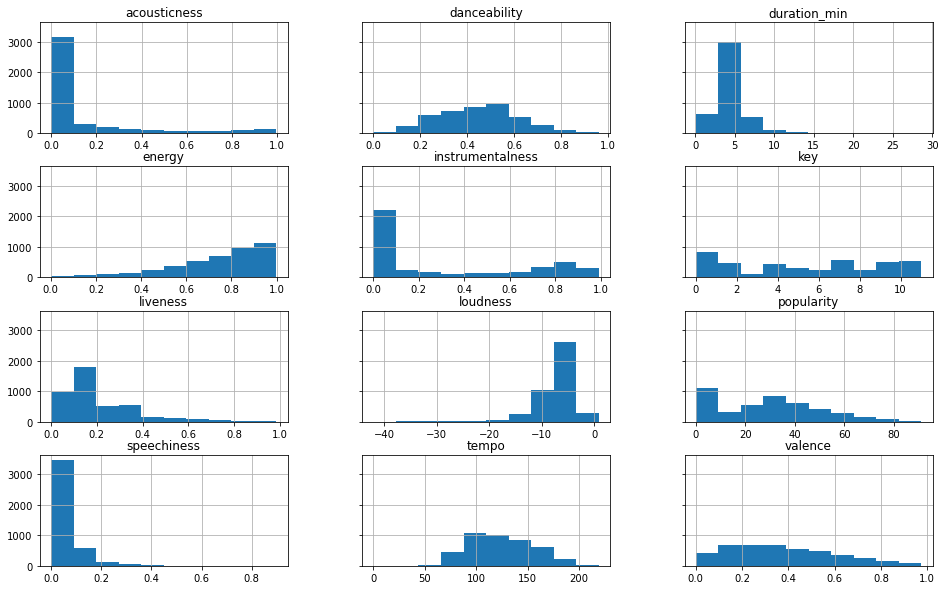

In [332]:
df[feat+['duration_min', 'popularity']].hist(sharey=True, figsize=(16, 10));

There is more 10 audio features given by Spotify, to view our songs in 1 view, I will apply a dimensionnality reduction algorithm to project in a 2D plane.
After that I will cluster on this plane.
Then we can see if the clustering make sense...

For T-SNE I applied 2 methods:
* scaled the data and apply euclidian
* apply mahalanobis distance aside and use it as a pre-calculated distance
Clearly. The mahalanobis distance gives better result (as it focus on group of data in similar distribution)

I tune the perplexity = n^(1/2) with n the number of observations (as KNN rule of thumbs)

In [333]:
from sklearn.preprocessing import minmax_scale
normalized = df[feat].apply(lambda x: (x - x.mean()) / x.std())
# normalized = df[feat].apply(minmax_scale)

In [334]:
from scipy.spatial.distance import pdist, squareform
mahalanobis_dist = squareform(pdist(df[feat], metric='mahalanobis'))

65

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4316 samples in 0.022s...
[t-SNE] Computed neighbors for 4316 samples in 0.284s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4316
[t-SNE] Computed conditional probabilities for sample 2000 / 4316
[t-SNE] Computed conditional probabilities for sample 3000 / 4316
[t-SNE] Computed conditional probabilities for sample 4000 / 4316
[t-SNE] Computed conditional probabilities for sample 4316 / 4316
[t-SNE] Mean sigma: 0.502544
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.755318
[t-SNE] KL divergence after 5000 iterations: 1.816127


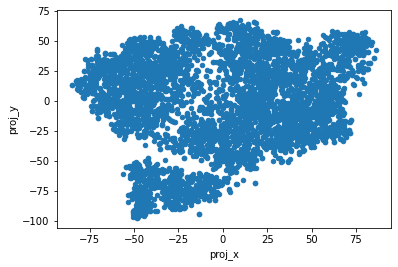

In [335]:
from sklearn.manifold import TSNE

display(int(df.shape[0]**(1/2)))

mdl_proj = TSNE(
    perplexity=50,
    n_jobs=4,
    n_iter=5_000,
    n_iter_without_progress=500,
    verbose=1,
    metric='precomputed',
    random_state=0
)

df[['proj_x', 'proj_y']] = pd.DataFrame(mdl_proj.fit_transform(mahalanobis_dist))
df[['proj_x', 'proj_y']].plot(kind='scatter', x='proj_x', y='proj_y');

Let's see a bit where the supergenre calculated previously are in this projection

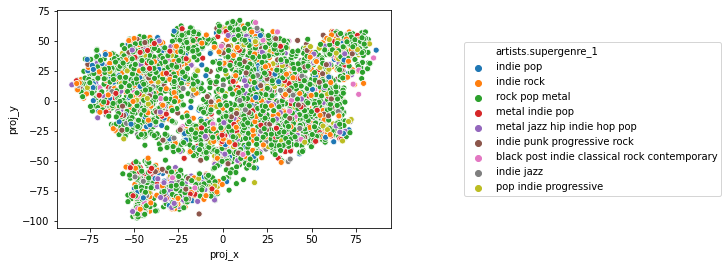

In [336]:
g = sns.scatterplot(data=df, x='proj_x', y='proj_y', hue='artists.supergenre_1', legend='full');
g.legend(loc='center right', bbox_to_anchor=(2, 0.5), ncol=1);

This is expected, and even as intended, I am not focusing on a music genre, but on a music audio, for example a group of "sad" songs of multilple genres...

I fine-tuned HDBSCAN with the min_cluster_size and let min_samples be found
min_cluster_size should be similar to an album size (10-20) or a playlist size (50-100)
the size of 16 seems the magic (other size around does not give similar clusters number and size)

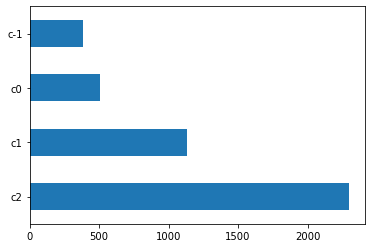

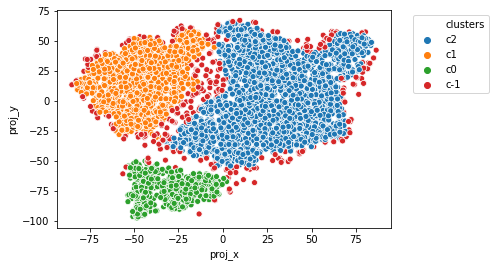

In [373]:
from hdbscan import HDBSCAN

df['clusters'] = HDBSCAN(min_cluster_size=50, min_samples=20)\
                    .fit_predict(df[['proj_x', 'proj_y']], min)
df['clusters'] = df['clusters'].map(lambda x: f'c{x}')

plt.figure()
df['clusters'].value_counts().plot(kind='barh');

plt.figure()
sns.scatterplot('proj_x', 'proj_y', data=df, hue='clusters');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

Let's see if those clusters make sense by printing each 10 most popular songs

In [374]:
col = feat+[
    'clusters',
    'proj_x',
    'proj_y',
    'popularity',
    'duration_min',
    'name',
    'artists.name',
    'album.name',
    'artists.genres',
    'artists.supergenres',
    'artists.supergenre_1',
    'external_urls.spotify',
    'preview_url'
]

df_top5 = df[col].groupby('clusters').apply(
    lambda x: x.sort_values('popularity', ascending=False).head(5)
)

df_top5

danceability  energy  key  loudness  speechiness  acousticness  \
clusters                                                                        
c-1      1907         0.818  0.7050    6    -6.679       0.1770      0.008360   
         3285         0.558  0.5590    6    -9.222       0.0959      0.371000   
         1162         0.663  0.6940   10    -8.627       0.1720      0.024900   
         4261         0.625  0.7630    8    -4.997       0.1290      0.147000   
         949          0.663  0.6940   10    -8.627       0.1720      0.024900   
c0       185          0.560  0.4420    5    -7.224       0.0243      0.727000   
         4280         0.705  0.3730    7    -9.066       0.0384      0.723000   
         3601         0.671  0.7120    2    -7.815       0.0476      0.429000   
         3755         0.357  0.4250    5    -7.301       0.0333      0.584000   
         2679         0.384  0.7650    6    -4.463       0.0579      0.646000   
c1       1164         0.689  0.7390    2    -5.810       0.0260      0.000015   
         2539         0.443  0.9560    2    -6.198       0.0511      0.000052   
         561          0.221  0.0879    7   -16.996       0.0381      0.155000   
         3602         0.906  0.6300    0    -8.071       0.0575      0.000547   
         2145         0.404  0.7200   10    -9.180       0.0623      0.000056   
c2       2584         0.834  0.7300    8    -3.714       0.2220      0.005130   
         2985         0.701  0.4250    7   -10.965       0.3750      0.328000   
         3702         0.808  0.7450   10    -5.260       0.3420      0.145000   
         3283         0.640  0.7400    4    -4.083       0.0284      0.011500   
         1470         0.556  0.8640    3    -5.870       0.0584      0.009580   

               instrumentalness  liveness  valence    tempo clusters  \
clusters                                                               
c-1      1907          0.002330    0.6130   0.7720  138.559      c-1   
         3285          0.000007    0.1090   0.6200   78.558      c-1   
         1162          0.000000    0.0698   0.5240  167.964      c-1   
         4261          0.010600    0.2140   0.7210   88.753      c-1   
         949           0.000000    0.0698   0.5240  167.964      c-1   
c0       185           0.000017    0.1100   0.2120  146.448       c0   
         4280          0.810000    0.2890   0.5510  120.046       c0   
         3601          0.000000    0.1030   0.4620  113.805       c0   
         3755          0.000000    0.3220   0.2700  102.078       c0   
         2679          0.003520    0.5220   0.5670  129.903       c0   
c1       1164          0.509000    0.0640   0.5780  120.423       c1   
         2539          0.825000    0.1350   0.9090  146.754       c1   
         561           0.698000    0.0869   0.0401  126.622       c1   
         3602          0.616000    0.0994   0.3420  122.458       c1   
         2145          0.836000    0.0466   0.4750  121.864       c1   
c2       2584          0.000000    0.1240   0.4460  155.008       c2   
         2985          0.130000    0.1000   0.5620  135.128       c2   
         3702          0.000000    0.2920   0.8290  165.995       c2   
         3283          0.006780    0.1670   0.7850  116.879       c2   
         1470          0.000000    0.2090   0.4000  105.143       c2   

                  proj_x     proj_y  popularity  duration_min  \
clusters                                                        
c-1      1907  57.504944  53.002838          81      3.710667   
         3285  43.407360 -42.689281          79      3.006433   
         1162  81.547729  26.934149          74      5.682000   
         4261  44.909252 -42.058460          74      3.202667   
         949   81.497208  26.651896          74      5.682000   
c0       185  -22.991850 -74.212364          83      5.160000   
         4280 -43.692089 -60.091431          81      3.467100   
         3601 -10.113919 -73.927246          80      4.140667 

An interactive plot with px would help see where the songs are in the projection and what they are

In [375]:
df_top5['hover_text'] = df_top5.apply(
    lambda x:
        f'Preview Song: <a href="{x["preview_url"]}">Play</a><br>' +
        f'Full Song: <a href="{x["external_urls.spotify"]}">Play</a><br>' +
        f'Track: {x["name"]}<br>' +
        f'Artist: {x["artists.name"]}<br>' +
        f'Album: {x["album.name"]}<br>' +
        # f'Genres: {x["artists.genres"]}<br>'+
        # f'Super Genres: {x["artists.supergenres"]}<br>' +
        f'Super Genre 1: {x["artists.supergenre_1"]}<br>',
    axis=1
)

df_top5['size'] = df_top5['popularity'].apply(lambda x: np.log10(x+1))

In [376]:
import plotly.express as px

px.scatter(
    df_top5,
    x='proj_x',
    y='proj_y',
    hover_data=['hover_text'],
    text=df_top5['external_urls.spotify'].map(lambda x: f'<a href="{x}">Play</a>'),
    size='size',
    color='clusters',
    color_discrete_sequence=px.colors.qualitative.Safe,
)